In [1]:
# Import Packages 

import numpy as np 
import matplotlib.pyplot as plt

# implemented algorithms available in sklearn, in order to compare to our models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Load variables
x_train_dataset = np.load('Xtrain_Regression1.npy');
y_train_dataset = np.load('Ytrain_Regression1.npy');
x_test = np.load('Xtest_Regression1.npy');

In [3]:
# check dimensions
print('X train dataset dimensions = ', x_train_dataset.shape)
print('Y train dataset dimensions = ', y_train_dataset.shape)
print('X test dataset dimensions = ', x_test.shape)

X train dataset dimensions =  (100, 10)
Y train dataset dimensions =  (100, 1)
X test dataset dimensions =  (1000, 10)


#### Pre-processing function

In [4]:
def pre_processing(x_train_dataset, y_train_dataset, center = True):
    
    if center:
        # defining a new set of coordinates that is located in 
        # the center of the data (zero mean) 
        Xdesign = x_train_dataset - np.mean(x_train_dataset, axis = 0) # design matrix
        Y = y_train_dataset - np.mean(y_train_dataset, axis = 0)
        
    else:
        Xdesign = np.append(np.ones((x_train_dataset.shape[0], 1)), x_train_dataset, axis = 1) # design matrix
        Y = y_train_dataset
        
    return Xdesign, Y

#### Estimation of the model's coefficients:

In [5]:
def Beta(X,y, center, *var_lambda, regularization = None):
    
    # preprocessing of the data: 
    Xdesign, Y = pre_processing(X,y, center) 
    
    # learning of the model, by minimizing the SSE
    if regularization == None:
        beta = np.linalg.pinv(Xdesign)@Y
        
    elif regularization == 'ridge':
        
        XT = np.transpose(Xdesign)
        
        beta = np.linalg.inv(XT@Xdesign + var_lambda*np.identity(Xdesign.shape[1]))@(XT@Y)
    
    elif regularization == 'lasso':
        lasso = Lasso(alpha=var_lambda[0], max_iter=10000, fit_intercept = ~center)
        lasso.fit(Xdesign, Y)
        beta = lasso.coef_[:, None]
    
    if center:
        # invert the pre-processing of centering the training data, in order to be applied to the non-centered test data 
        beta0_hat = np.mean(y, axis = 0) - np.mean(X, axis = 0)[None, :]@beta

        beta = np.append(beta0_hat, beta, axis = 0)
    
    return beta

#### Predictor function

In [6]:
def y_pred(X, beta): 
    
    # Design matrix, adding a column of 1s, representing the offset
    X = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
    
    # linear combination of the features, plus the offset
    y_hat = X@beta 
    
    return y_hat

#### Error function

In [7]:
def Error(Y, y_pred):
    
    # the components of the vector Y-y_pred are the errors of 
    # each training example
    e = Y - y_pred 
    
    SSE = np.transpose(e)@e

    return SSE

#### Data Visualization functions

In [8]:
# Visualization of the data

def graphics(var_x, var_y, title, betas = np.array([])):

    fig, axs = plt.subplots(5, 2, figsize=(15, 20))
    
    for num_variable, ax in zip(range(var_x.shape[1]), axs.ravel()):
        ax.plot(var_x[:,num_variable], var_y, '*') 
        
        ax.set_xlabel('$x_n$')
        ax.set_ylabel('$y_n$')
        ax.set_title('Feature'+str(num_variable+1))
        plt.axis('tight')
        
        if betas.any():
            step = (max(var_x[:,num_variable])-min(var_x[:,num_variable]))/100
            x_values = np.arange(min(var_x[:,num_variable]), max(var_x[:,num_variable])+step, step) 
            y_pred = betas[num_variable, 0]*x_values
            ax.plot(x_values, y_pred, '--r') 
                        
    fig.suptitle(title, fontsize=18, y=0.9)
    plt.subplots_adjust(wspace=0.3,hspace=0.4)
    plt.show()

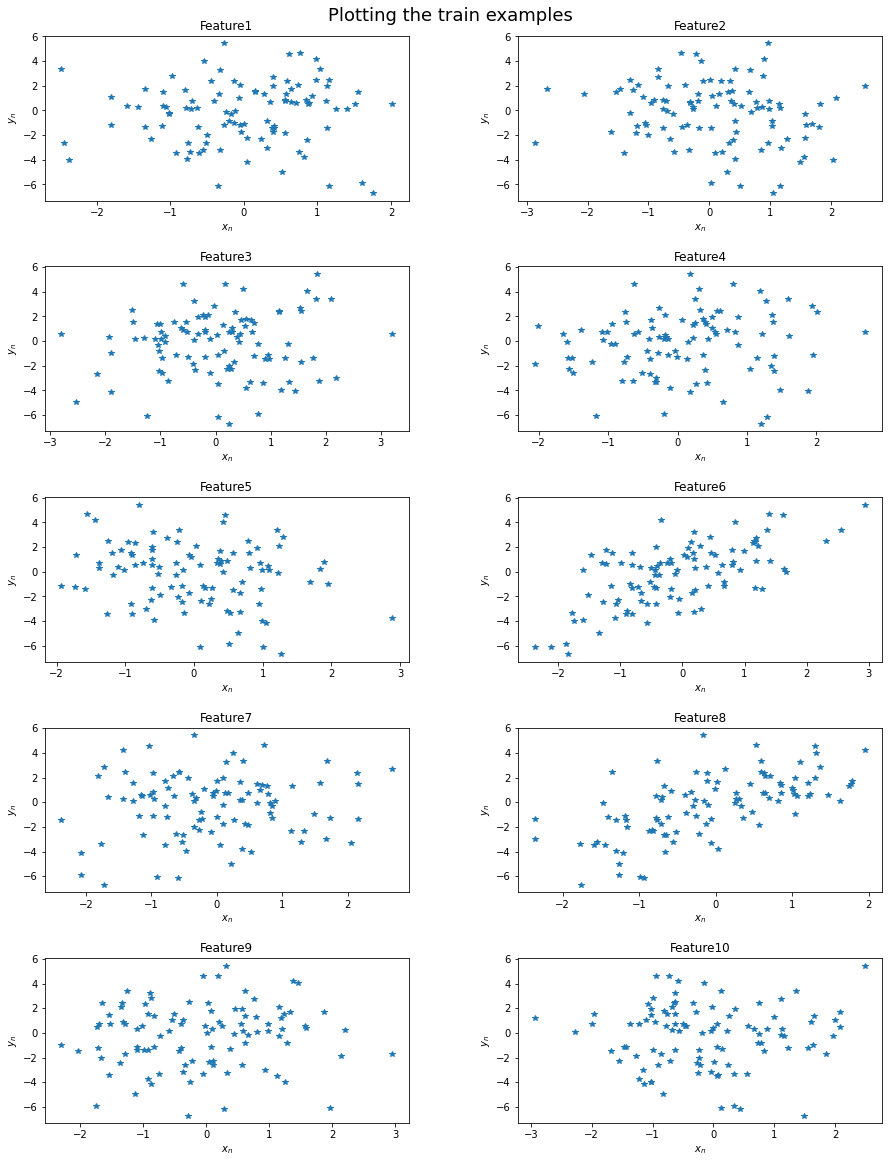

In [9]:
graphics(x_train_dataset, y_train_dataset, 'Plotting the train examples')

#### Performance evaluation: Cross validation function

In [10]:
nfolds = 10
nrepeats = 3

def cross_val(model, X, Y, center, nfolds, nrepeats, *var_lambda):
    
    n_scores = []

    rkf = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1)
    
    for train_index, test_index in rkf.split(X):
        Xtrain, Ytrain = X[train_index], Y[train_index]
        Xtest, Ytest = X[test_index], Y[test_index]
        
        SSE, _ = model(Xtrain, Ytrain, Xtest, Ytest, center, *var_lambda)
                
        n_scores.append(SSE)
    
    mean_scores = np.mean(n_scores)
    std_scores = np.std(n_scores)

    return mean_scores, std_scores

## Model 1. Simple linear regression

In [11]:
def lineareg_model(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center):
    
    # learning of the model's coefficients, by minimizing the SSE
    beta = Beta(x_train_dataset, y_train_dataset, center)
    
    # calculate the predictions of y on the test data
    y_hat = y_pred(x_test_dataset, beta)
    
    # Evaluate the SSE
    SSE = Error(y_test_dataset, y_hat)
    
    return SSE, y_hat

In [12]:
center = True

n_scores_model1 = cross_val(lineareg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats)

print('SSE: %f ± %f' % (n_scores_model1[0], n_scores_model1[1]))

SSE: 0.128700 ± 0.049624


#### Comparison with sklearn model (check if results are similar):

In [13]:
lin_reg = LinearRegression(fit_intercept = True)

# evaluate the model:
cv = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1)
n_scores = cross_val_score(lin_reg, x_train_dataset, y_train_dataset, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

# report model performance
print('SSE: %f ± %f' % (np.mean(nfolds*abs(n_scores)), np.std(nfolds*abs(n_scores))))

SSE: 0.128700 ± 0.049624


## Model 2. Ridge Regression

In [14]:
def ridgereg_model(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center, var_lambda):
    
    # learning of the model's coefficients
    beta = Beta(x_train_dataset, y_train_dataset, center, var_lambda, regularization = 'ridge')
    
    # calculate the predictions of y on the test data
    y_hat = y_pred(x_test_dataset, beta)
    
    # Evaluate the SSE
    SSE = Error(y_test_dataset, y_hat)
    
    return SSE, y_hat

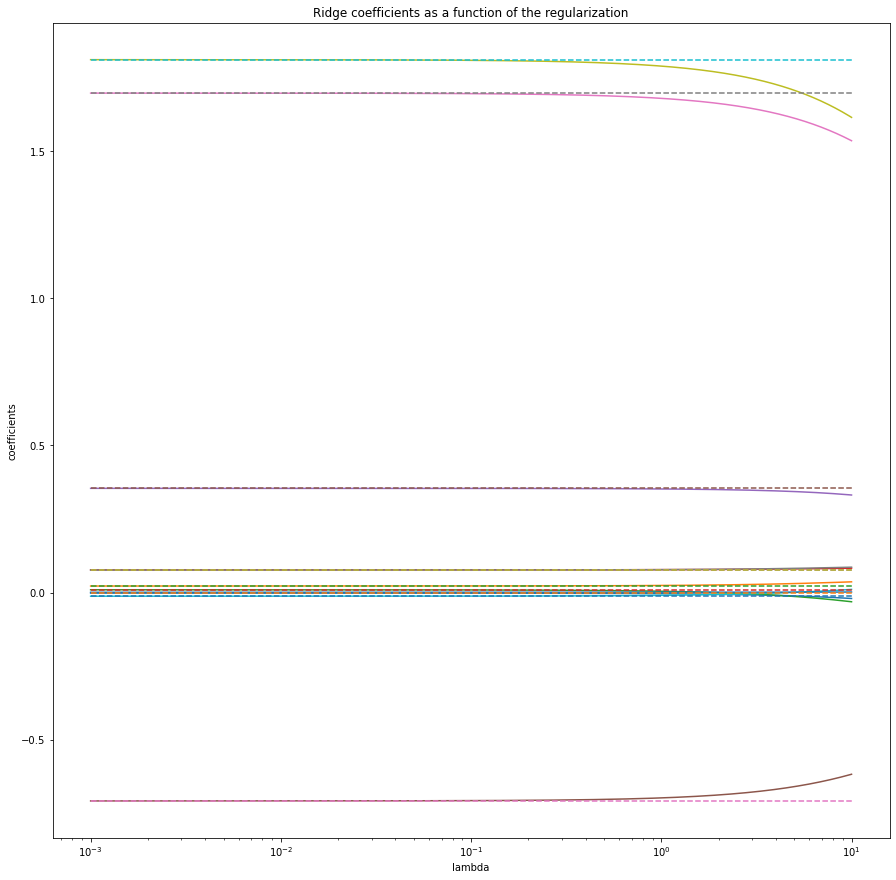

In [15]:
lambdas = np.arange(10**(-3),10,0.01)

betaRidge = []

center = True

for var_lambda in lambdas:
    beta_ridge = Beta(x_train_dataset, y_train_dataset, center, var_lambda, regularization = 'ridge')
    
    betaRidge.append(np.reshape(beta_ridge,(x_train_dataset.shape[1]+1,)))
        
betaRidge=np.asarray(betaRidge)

betaLinear = Beta(x_train_dataset, y_train_dataset, center)

plt.figure(1, (15,15))
ax = plt.gca()
ax.plot(lambdas, betaRidge) 
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[0,0], linestyle ='--') 
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[1,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[2,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[3,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[4,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[5,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[6,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[7,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[8,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[9,0],linestyle ='--')

ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('coefficients')
plt.axis('tight')

plt.title('Ridge coefficients as a function of the regularization')
plt.show()

In [16]:
lambdas_ridge = [0.001, 0.01, 0.05, 0.08, 0.1, 0.2, 0.5, 1.0]

n_scores_model2_mean_all = []
n_scores_model2_std_all = []

center = True

for var_lambda in lambdas_ridge:
    n_scores_model2 = cross_val(ridgereg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)
    
    n_scores_model2_mean_all.append(n_scores_model2[0])
    n_scores_model2_std_all.append(n_scores_model2[1])
    
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f  ' % (n_scores_model2[0], n_scores_model2[1]))    
    
idx_best_ridge = np.argmin(n_scores_model2_mean_all)
lambda_best = lambdas_ridge[idx_best_ridge]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_model2_mean_all[idx_best_ridge], n_scores_model2_std_all[idx_best_ridge]))

SSE, lambda = 0.001: 0.128702 ± 0.049643  
SSE, lambda = 0.01: 0.128718 ± 0.049812  
SSE, lambda = 0.05: 0.128813 ± 0.050575  
SSE, lambda = 0.08: 0.128914 ± 0.051160  
SSE, lambda = 0.1: 0.128994 ± 0.051555  
SSE, lambda = 0.2: 0.129556 ± 0.053602  
SSE, lambda = 0.5: 0.132831 ± 0.060423  
SSE, lambda = 1.0: 0.143427 ± 0.073997  
SSE of the best model, lambda = 0.001: 0.128702 ± 0.049643  


#### Comparison with sklearn model (check if results are similar):

In [17]:
# evaluate the model:
cv = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1)

n_scores_ridge_mean_all = []
n_scores_ridge_std_all = []

for var_lambda in lambdas_ridge: 
    ridge = Ridge(alpha = var_lambda, max_iter=10000)
    
    n_scores_ridge = cross_val_score(ridge, x_train_dataset, y_train_dataset, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    
    n_scores_ridge_mean_all.append(np.mean(nfolds*abs(n_scores_ridge)))
    n_scores_ridge_std_all.append(np.std(nfolds*abs(n_scores_ridge)))
    
    #report model performance
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f  ' % (np.mean(nfolds*abs(n_scores_ridge)), np.std(nfolds*abs(n_scores_ridge)))) 
    
idx_best_ridge = np.argmin(n_scores_ridge_mean_all)
lambda_best = lambdas_ridge[idx_best_ridge]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_ridge_mean_all[idx_best_ridge], n_scores_ridge_std_all[idx_best_ridge]))

SSE, lambda = 0.001: 0.128702 ± 0.049643  
SSE, lambda = 0.01: 0.128718 ± 0.049812  
SSE, lambda = 0.05: 0.128813 ± 0.050575  
SSE, lambda = 0.08: 0.128914 ± 0.051160  
SSE, lambda = 0.1: 0.128994 ± 0.051555  
SSE, lambda = 0.2: 0.129556 ± 0.053602  
SSE, lambda = 0.5: 0.132831 ± 0.060423  
SSE, lambda = 1.0: 0.143427 ± 0.073997  
SSE of the best model, lambda = 0.001: 0.128702 ± 0.049643  


## Model 3. Lasso Regression

In [18]:
def lassoreg_model(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center, var_lambda):
    
    # learning of the model's coefficients. this can't be obtained analitically,
    # being an optimization problem
    beta = Beta(x_train_dataset, y_train_dataset, center, var_lambda, regularization = 'lasso')
    
    # calculate the predictions of y on the test data
    y_hat = y_pred(x_test_dataset, beta)
    
    # Evaluate the SSE
    SSE = Error(y_test_dataset, y_hat)
    
    return SSE, y_hat

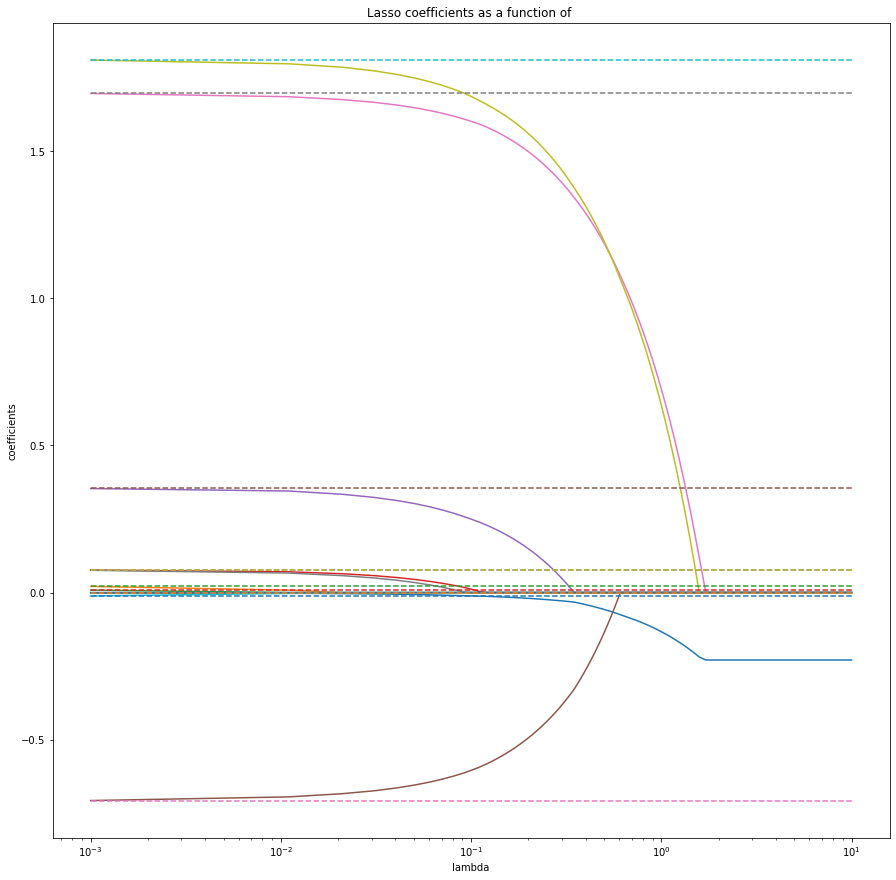

In [19]:
lambdas = np.arange(10**(-3),10,0.01)

betaLasso = []

center = True

for var_lambda in lambdas:
    beta_lasso = Beta(x_train_dataset, y_train_dataset, center, var_lambda, regularization = 'lasso')
    
    betaLasso.append(np.reshape(beta_lasso,(x_train_dataset.shape[1]+1,)))
        
betaLasso=np.asarray(betaLasso)

plt.figure(1, (15,15))
ax = plt.gca()
ax.plot(lambdas, betaLasso) 
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[0,0], linestyle ='--') 
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[1,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[2,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[3,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[4,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[5,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[6,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[7,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[8,0],linestyle ='--')
ax.plot(lambdas,np.ones(len(lambdas))*betaLinear[9,0],linestyle ='--')

ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('coefficients')
plt.axis('tight')

plt.title('Lasso coefficients as a function of ')
plt.show()

In [20]:
lambdas_lasso = [0.0001, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

n_scores_model3_mean_all = []
n_scores_model3_std_all = []

center = True

for var_lambda in lambdas_lasso:
    n_scores_model3 = cross_val(lassoreg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)
    
    n_scores_model3_mean_all.append(n_scores_model3[0])
    n_scores_model3_std_all.append(n_scores_model3[1])
        
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f  ' % (n_scores_model3[0], n_scores_model3[1]))
    
idx_best_lasso = np.argmin(n_scores_model3_mean_all)
lambda_best = lambdas_lasso[idx_best_lasso]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_model3_mean_all[idx_best_lasso], n_scores_model3_std_all[idx_best_lasso]))

SSE, lambda = 0.0001: 0.128655 ± 0.049815  
SSE, lambda = 0.001: 0.128361 ± 0.051596  
SSE, lambda = 0.0015: 0.128316 ± 0.052631  
SSE, lambda = 0.002: 0.128305 ± 0.053592  
SSE, lambda = 0.005: 0.129904 ± 0.059757  
SSE, lambda = 0.01: 0.136637 ± 0.070860  
SSE, lambda = 0.05: 0.307342 ± 0.184161  
SSE, lambda = 0.1: 0.786645 ± 0.426901  
SSE, lambda = 0.5: 11.274318 ± 5.696400  
SSE, lambda = 1: 29.838892 ± 16.119048  
SSE of the best model, lambda = 0.002: 0.128305 ± 0.053592  


#### Comparison with sklearn model (check if results are similar):

In [21]:
# evaluate the model:
cv = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=1)

n_scores_lasso_mean_all = []
n_scores_lasso_std_all = []

for var_lambda in lambdas_lasso: 
    lasso = Lasso(alpha = var_lambda, max_iter=10000)
    
    n_scores_lasso = cross_val_score(lasso, x_train_dataset, y_train_dataset, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    
    n_scores_lasso_mean_all.append(np.mean(nfolds*abs(n_scores_lasso)))
    n_scores_lasso_std_all.append(np.std(nfolds*abs(n_scores_lasso)))
    
    # report model performance
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f  ' % (np.mean(nfolds*abs(n_scores_lasso)), np.std(nfolds*abs(n_scores_lasso))))    
    
idx_best_lasso = np.argmin(n_scores_lasso_mean_all)
lambda_best = lambdas_lasso[idx_best_lasso]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_lasso_mean_all[idx_best_lasso], n_scores_lasso_std_all[idx_best_lasso]))

SSE, lambda = 0.0001: 0.128655 ± 0.049815  
SSE, lambda = 0.001: 0.128361 ± 0.051596  
SSE, lambda = 0.0015: 0.128316 ± 0.052631  
SSE, lambda = 0.002: 0.128305 ± 0.053592  
SSE, lambda = 0.005: 0.129904 ± 0.059757  
SSE, lambda = 0.01: 0.136637 ± 0.070860  
SSE, lambda = 0.05: 0.307342 ± 0.184161  
SSE, lambda = 0.1: 0.786645 ± 0.426901  
SSE, lambda = 0.5: 11.274318 ± 5.696400  
SSE, lambda = 1: 29.838892 ± 16.119048  
SSE of the best model, lambda = 0.002: 0.128305 ± 0.053592  


## Model 4. Linear Regression after Feature Selection with Lasso

In [22]:
# function that performs linear regression only on the features selected by lasso, for a given lambda

def lineareg_lasso_dropout(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center, var_lambda):
    
    # estimation of the lasso model's coefficients
    beta_lasso = Beta(x_train_dataset, y_train_dataset, center, var_lambda, regularization = 'lasso')
    
    # check coefficients that are 0 
    deleted_features = np.asarray(np.where(beta_lasso == 0))
    
    deleted_features_list = []
    
    # remove the unimportant features determined by lasso
    for idx in range(deleted_features.shape[1]):
        
        # subtract by 1 since beta_lasso contains an additional parameter, the offset
        feature = deleted_features[0,idx] - 1 
        
        deleted_features_list.append(feature)
        
    x_train_dataset_new = np.delete(x_train_dataset, deleted_features_list, 1)        
    x_test_dataset_new = np.delete(x_test_dataset, deleted_features_list, 1)
        
    # learning of the model's coefficients, by minimizing the SSE
    beta = Beta(x_train_dataset_new, y_train_dataset, center)
    
    # calculate the predictions of y on the test data
    y_hat = y_pred(x_test_dataset_new, beta)
    
    # Evaluate the SSE
    SSE = Error(y_test_dataset, y_hat)
    
    return SSE, y_hat

In [23]:
lambdas_lasso_dropout = [0.0001, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

center = True

n_scores_model4_mean_all = []
n_scores_model4_std_all = []

for var_lambda in lambdas_lasso_dropout:
    n_scores_model4 = cross_val(lineareg_lasso_dropout, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)
    
    n_scores_model4_mean_all.append(n_scores_model4[0])
    n_scores_model4_std_all.append(n_scores_model4[1])
    
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f' % (n_scores_model4[0], n_scores_model4[1]))

idx_best_lasso = np.argmin(n_scores_model4_mean_all)
lambda_best = lambdas_lasso[idx_best_lasso]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_model4_mean_all[idx_best_lasso], n_scores_model4_std_all[idx_best_lasso]))
                                                                               

SSE, lambda = 0.0001: 0.128701 ± 0.049624
SSE, lambda = 0.001: 0.128665 ± 0.049632
SSE, lambda = 0.0015: 0.128657 ± 0.049626
SSE, lambda = 0.002: 0.128720 ± 0.049993
SSE, lambda = 0.005: 0.127918 ± 0.050391
SSE, lambda = 0.01: 0.129483 ± 0.052815
SSE, lambda = 0.05: 0.128111 ± 0.058564
SSE, lambda = 0.1: 0.236451 ± 0.124629
SSE, lambda = 0.5: 1.499175 ± 0.740610
SSE, lambda = 1: 6.959932 ± 2.820262
SSE of the best model, lambda = 0.005: 0.127918 ± 0.050391  


## Model 5. Stepwise Feature Selection 

In [24]:
# function that performs stepwise-elimination of the features, appying a linear regression model to them, if it improves the performance of the model

def feature_dropout(x_train_dataset, y_train_dataset, center, nfolds, nrepeats):
    
    features_dropout = []
    
    prev_mean, prev_std = cross_val(lineareg_model, x_train_dataset, y_train_dataset, center, nfolds, nrepeats)
    
    rkf = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=1)
    
    # deletes features stepwise and progressively
    for feature in range(x_train_dataset.shape[1]):
        features_dropout.append(feature)
                
        x_train_dataset_new = np.delete(x_train_dataset, features_dropout, 1)
        
        current_mean, current_std = cross_val(lineareg_model, x_train_dataset_new, y_train_dataset, center, nfolds, nrepeats)
        
        if current_mean >= prev_mean:
            features_dropout.remove(feature)
        else:
            prev_mean = current_mean 
            prev_std = current_std
    
    print('Dropout Features: {}'.format(features_dropout))
    
    return prev_mean, prev_std

In [25]:
center = True

n_score_model5 = feature_dropout(x_train_dataset, y_train_dataset, center, nfolds, nrepeats)
print('SSE: %f ± %f' % (n_score_model5[0], n_score_model5[1]))

Dropout Features: [1, 8, 9]
SSE: 0.124332 ± 0.050387


## Polynomial model  

In [26]:
def poly_regression(x_train_dataset, y_train_dataset, x_test_dataset, y_test_dataset, center, var_lambda):

    poly = PolynomialFeatures(degree = 2, include_bias=~center)
    Xtrain_poly = poly.fit_transform(x_train_dataset)
    Xtest_poly = poly.fit_transform(x_test_dataset)
            
    if var_lambda == 0:
        SSE, y_hat = lineareg_model(Xtrain_poly, y_train_dataset, Xtest_poly, y_test_dataset, center)
    else:
        SSE, y_hat = lassoreg_model(Xtrain_poly, y_train_dataset, Xtest_poly, y_test_dataset, center, var_lambda)
                
    return SSE, y_hat

## Model 6. Polynomial Model with simple linear regression

In [27]:
center = True

n_score_model6 = cross_val(poly_regression, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, 0)

print('SSE: %f ± %f' % (n_score_model6[0], n_score_model6[1]))

SSE: 0.706738 ± 0.742086


## Model 7. Polynomial Model with Lasso Regularization

In [28]:
poly_lambdas = [0.0001, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

n_scores_model7_mean_all = []
n_scores_model7_std_all = []

center = False

for var_lambda in poly_lambdas:
    n_scores_model7 = cross_val(poly_regression, x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda)
        
    n_scores_model7_mean_all.append(n_scores_model7[0])
    n_scores_model7_std_all.append(n_scores_model7[1])
    
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f' % (n_scores_model7[0], n_scores_model7[1]))
    
idx_best_poly_lasso = np.argmin(n_scores_model7_mean_all)
lambda_best = poly_lambdas[idx_best_poly_lasso]

print('SSE of the best model, lambda = ' + str(lambda_best) + ': %f ± %f  ' % (n_scores_model7_mean_all[idx_best_poly_lasso], n_scores_model7_std_all[idx_best_poly_lasso]))

SSE, lambda = 0.0001: 0.644761 ± 0.628930
SSE, lambda = 0.001: 0.297150 ± 0.112473
SSE, lambda = 0.0015: 0.245287 ± 0.073656
SSE, lambda = 0.002: 0.221747 ± 0.065197
SSE, lambda = 0.005: 0.161821 ± 0.060564
SSE, lambda = 0.01: 0.145125 ± 0.071903
SSE, lambda = 0.05: 0.304702 ± 0.187468
SSE, lambda = 0.1: 0.778192 ± 0.433062
SSE, lambda = 0.5: 11.175439 ± 5.727711
SSE, lambda = 1: 29.679016 ± 16.255985
SSE of the best model, lambda = 0.01: 0.145125 ± 0.071903  


#### Comparison with sklearn model (check if results are similar):

In [29]:
def poly_regression_sklearn(x_train_dataset, y_train_dataset, center, nfolds, nrepeats, var_lambda):
    
    poly = PolynomialFeatures(degree = 2, include_bias=~center)
    
    if var_lambda == 0:
        poly_reg_model = LinearRegression(fit_intercept = ~center)
    else:
        poly_reg_model = Lasso(alpha = var_lambda, max_iter=10000, fit_intercept = ~center)
         
    poly_reg_model_pipeline = Pipeline([('poly', poly), ('regressor', poly_reg_model)])
    
    # evaluate the model
    cv = RepeatedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state=1)
    n_scores = cross_val_score(poly_reg_model_pipeline, x_train_dataset, y_train_dataset, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    
    # report model performance
    n_scores_mean = np.mean(nfolds*abs(n_scores))
    n_scores_std = np.std(nfolds*abs(n_scores))
    
    return n_scores_mean, n_scores_std

#### Polynomial Model with simple linear regression

In [30]:
X, Y = pre_processing(x_train_dataset, y_train_dataset)

center = False 

n_scores_poly = poly_regression_sklearn(x_train_dataset, y_train_dataset, center, nfolds, nrepeats, 0)

print('SSE: %f ± %f' % (n_scores_poly[0], n_scores_poly[1]))

SSE: 0.706738 ± 0.742086


#### Polynomial Model with Lasso Regularization

In [31]:
n_scores_poly_lasso_mean_all = []
n_scores_poly_lasso_std_all = []

center = True

for var_lambda in poly_lambdas:    
    n_scores_poly_lasso = poly_regression_sklearn(X, Y, center, nfolds, nrepeats, var_lambda)
    
    n_scores_poly_lasso_mean_all.append(n_scores_poly_lasso[0])
    n_scores_poly_lasso_std_all.append(n_scores_poly_lasso[1])
    
    print('SSE, lambda = ' + str(var_lambda) + ': %f ± %f' % (n_scores_poly_lasso[0], n_scores_poly_lasso[1]))

SSE, lambda = 0.0001: 0.608108 ± 0.571878
SSE, lambda = 0.001: 0.293084 ± 0.105784
SSE, lambda = 0.0015: 0.245513 ± 0.072929
SSE, lambda = 0.002: 0.223408 ± 0.065177
SSE, lambda = 0.005: 0.163836 ± 0.061235
SSE, lambda = 0.01: 0.148218 ± 0.073337
SSE, lambda = 0.05: 0.310909 ± 0.189647
SSE, lambda = 0.1: 0.790289 ± 0.435322
SSE, lambda = 0.5: 11.274318 ± 5.696402
SSE, lambda = 1: 29.838892 ± 16.119048


## Conclusions

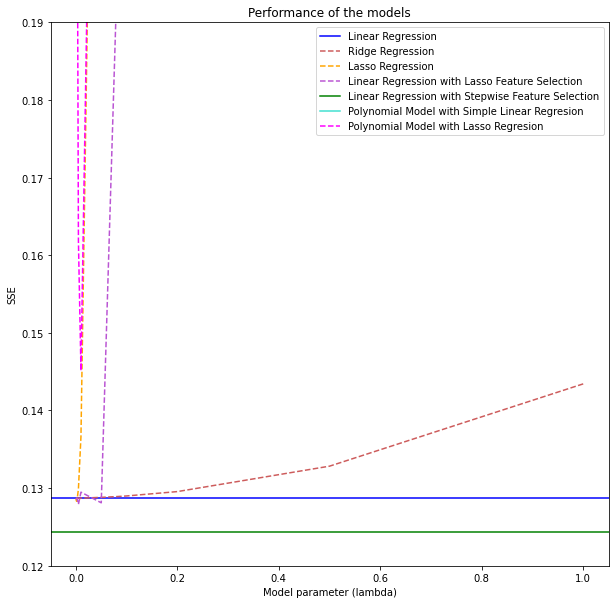

In [32]:
plt.figure(figsize=(10,10))
plt.axhline(n_scores_model1[0], c='b', label = 'Linear Regression')
plt.plot(lambdas_ridge, n_scores_model2_mean_all, '--', c='indianred', label = 'Ridge Regression')
plt.plot(lambdas_lasso, n_scores_model3_mean_all, '--',c='orange', label = 'Lasso Regression')
plt.plot(lambdas_lasso_dropout, n_scores_model4_mean_all, '--',c='mediumorchid', label = 'Linear Regression with Lasso Feature Selection')
plt.axhline(n_score_model5[0], c='g', label = 'Linear Regression with Stepwise Feature Selection')
plt.axhline(n_score_model6[0], c='turquoise', label = 'Polynomial Model with Simple Linear Regresion')
plt.plot(poly_lambdas, n_scores_model7_mean_all, '--',c='magenta', label = 'Polynomial Model with Lasso Regresion')

plt.legend()
plt.title('Performance of the models')
plt.ylim([0.12, 0.19])
plt.ylabel('SSE')
plt.xlabel('Model parameter (lambda)')
plt.show()

Among the models' performance evaluation, the linear regression with stepwise feature Selection stands-out as the best model, given the input data. Therefore, this model was the selected one for computing the test set predictions:

In [33]:
features_dropout = [1,8,9] # features determined to be unimportant 

Xtrain = np.delete(x_train_dataset, features_dropout, axis = 1)
Xtest = np.delete(x_test, features_dropout, axis = 1)

center = True 

beta = Beta(Xtrain, y_train_dataset, center)

y_hat = y_pred(Xtest, beta)

print(y_hat)
np.save("y_hat.npy", y_hat)

[[ 7.80518739e+00]
 [-1.77119112e-01]
 [ 4.72852715e+00]
 [ 1.17830642e+00]
 [-1.85308949e+00]
 [ 1.79929799e+00]
 [ 2.19741685e+00]
 [ 3.04077461e+00]
 [-1.45031954e+00]
 [ 3.44315133e+00]
 [ 2.14415517e+00]
 [-5.96101083e-01]
 [ 1.90137479e+00]
 [ 4.34509868e+00]
 [-2.75890228e+00]
 [-2.15641522e+00]
 [-2.10481694e+00]
 [-3.70387031e+00]
 [ 4.00225593e-01]
 [-2.83493734e+00]
 [ 3.49050075e-01]
 [ 2.12764950e+00]
 [ 4.41136947e-01]
 [ 7.07019514e-01]
 [ 9.73645521e-01]
 [ 3.60314712e-01]
 [-1.00472161e+00]
 [-3.93821011e-01]
 [-2.17335611e+00]
 [ 5.40013661e+00]
 [-9.06585635e-01]
 [ 7.02169568e+00]
 [-3.72046108e+00]
 [ 4.40176419e-02]
 [-9.34465239e-01]
 [ 3.59413483e+00]
 [ 3.58335073e+00]
 [ 2.04718872e+00]
 [ 1.02914402e+00]
 [ 2.01768820e+00]
 [ 1.91738817e+00]
 [ 1.62045521e+00]
 [-2.09934185e-01]
 [-7.41779837e-01]
 [-1.46038322e+00]
 [-1.77031895e+00]
 [-2.35180121e+00]
 [ 1.66742946e+00]
 [-4.51154310e+00]
 [ 2.09620148e+00]
 [-1.29112352e+00]
 [ 1.57327980e+00]
 [ 1.9920546